In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from model.MinAggGNN import MinAggGNN
import matplotlib.pyplot as plt

device = torch.device('cuda')
L = 2
m = 2
eta = 0.0003
epochs = 20000

model = MinAggGNN(2, 8, L, 2, edge_dim = 1)
state_dict = torch.load('model_progress/simultaneous/model_final.pt')
checkpoints = torch.load('model_progress/simultaneous/model_checkpoints.pt')
model.load_state_dict(state_dict)
model.eval()
model.to(device)

MinAggGNN(2, 2, num_layers=2)

In [2]:
from MINAR.ComputationGraph import ComputationGraph, Circuit
from model.CustomLosses import MultiplicativeLoss
import torch_geometric as pyg
import networkx as nx

G = ComputationGraph(model)
G.add_inputs({'edge_attr' : [1, model.convs[0].agg_mlp.lins[0].weight[:,-1]],
              'input_self.0' : [3, model.convs[0].up_mlp.lins[0].weight[:,-2]],
              'input_self.1' : [3, model.convs[0].up_mlp.lins[0].weight[:,-1]]})
G.add_residual_connections({'edge_attr' : [5, model.convs[1].agg_mlp.lins[0].weight[:,-1].reshape(1,-1).cpu().detach()]})
G.add_residual_connections({4 : [7, model.convs[1].up_mlp.lins[0].weight[:,-8:].T.cpu().detach()]})

In [3]:
test_loss = MultiplicativeLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCEWithLogitsLoss()

def joint_loss(input, target,
               criteria,
               reduction = "sum",
               weight = None
               ):
    errors = torch.stack([criteria[i](input[:,i], target[:,i]) for i in range(len(criteria))])
    if weight is not None:
        errors = errors * weight

    if reduction == "none":
        return errors
    elif reduction == "sum":
        return torch.sum(errors)
    elif reduction == "mean":
        return torch.sum(errors) / torch.sum(weight)

class JointLoss(torch.nn.modules.loss._Loss):
    def __init__(self, criteria, is_classification, weight=None, size_average=None, reduce=None, reduction: str = "sum") -> None:
        super().__init__(size_average, reduce, reduction)
        self.criteria = criteria
        self.is_classification = is_classification
        self.weight = weight

    def forward(self, input, target):
        tmp_target = torch.empty_like(target, device=target.device)
        for i, is_class in enumerate(self.is_classification):
            if is_class:
                tmp_target[:,i] = target[:,i].sigmoid()
            else:
                tmp_target[:,i] = target[:,i]

        return joint_loss(input, tmp_target, self.criteria, reduction=self.reduction, weight=self.weight)
    
criterion = JointLoss([mse_loss, bce_loss], [False, True], weight=torch.tensor([1.,50.], device=device))

In [4]:
test_data = torch.load('data/test_data.pt', map_location=device)
test_loader = pyg.loader.DataLoader(test_data, batch_size = len(test_data))
num_reachable_test_nodes = sum([data.reachable.sum() for data in test_loader])
for data in test_data:
    data.x = torch.cat([data.x, data.x_bfs], 1)

corrupted_data = torch.load('data/test_data.pt', map_location=device)
for data_corr in corrupted_data:
    data_corr.x = torch.cat([data_corr.x, data_corr.x_bfs], 1)
    data_corr.x = torch.zeros_like(data_corr.x, device=device)
    data_corr.x[0,0] = 100.
    data_corr.x[:,1] = torch.ones_like(data_corr.x[:,1], device=device)
    data_corr.x[0,1] = 0.
    data_corr.edge_attr = torch.zeros_like(data_corr.edge_attr, device=device)

G.calculate_scores(test_data, corrupted_data, criterion, which = 'weight_grad')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP-IG', steps=5)

c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [10]:
# which = 'weight'
# which = 'EAP'
which = 'EAP-IG'
K = 25
C = Circuit(model, G, K=K, key=which)

print(C.number_of_edges())

for data in test_loader:
    out = C.forward(data)
    mul_circuit_loss = float(test_loss(out[:,0][data.reachable].flatten(), data.y[data.reachable]).detach()) / num_reachable_test_nodes
    bfs_accuracy = ((out[:,1].flatten() > 0) == data.reachable).sum().item() / data.num_nodes
    print(f'Circuit Test Loss: {mul_circuit_loss:.4f}, Test Acc: {bfs_accuracy:.4f}')

42


c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Circuit Test Loss: 0.0777, Test Acc: 0.9999


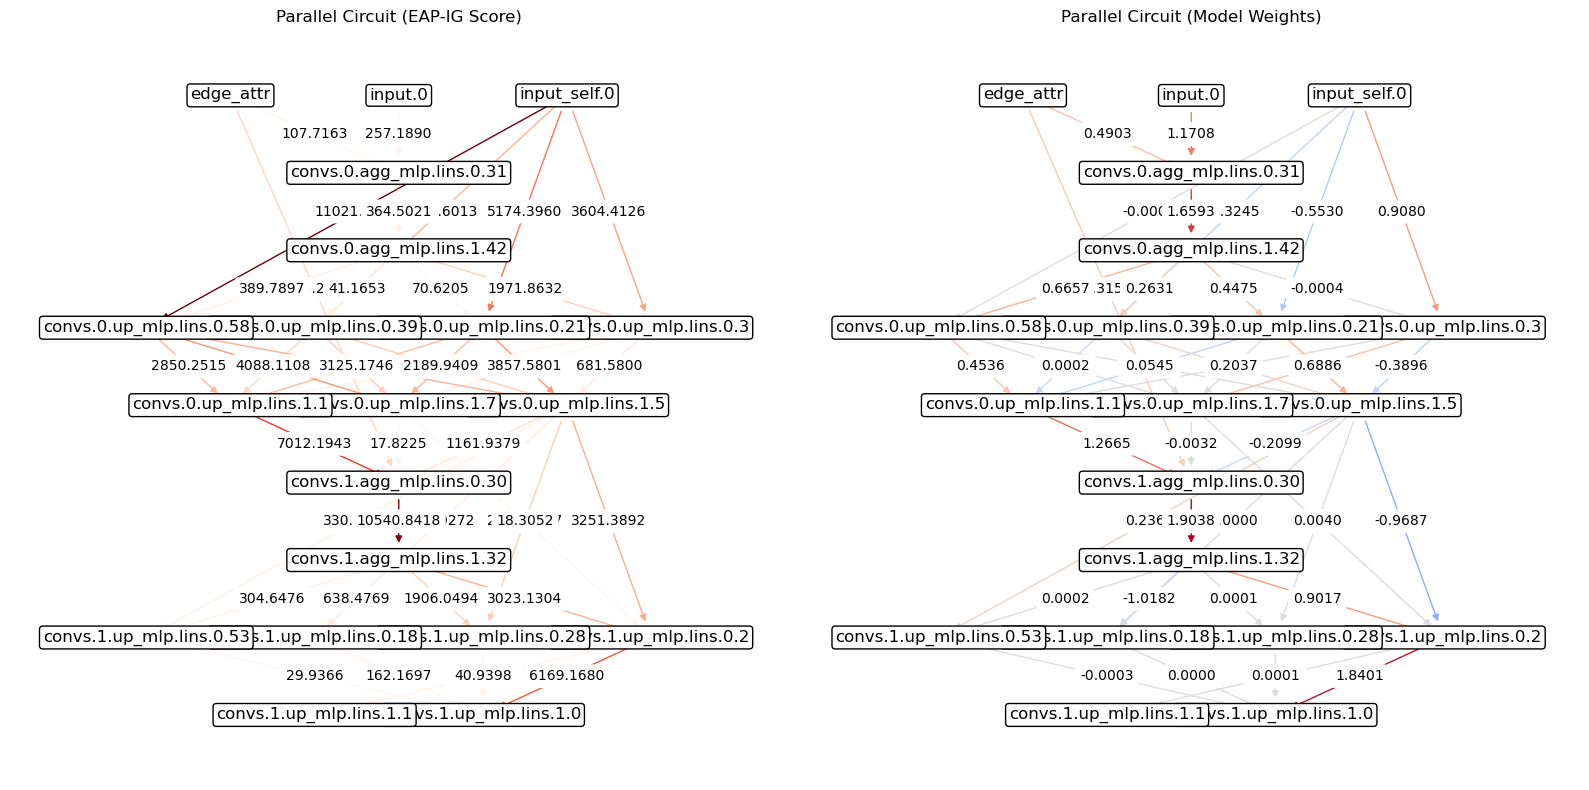

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
c_pos = nx.multipartite_layout(C, subset_key='layer', align='horizontal')
c_pos = {node: (x,-y) for (node, (x,y)) in c_pos.items()}

circuit_edges, circuit_edge_scores = zip(*nx.get_edge_attributes(C,which).items())
nx.draw(C, pos = c_pos, ax=ax[0],
        with_labels=True,
        node_shape="s",
        node_color="none",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"),
        edge_color=circuit_edge_scores,
        edge_cmap=plt.cm.Reds,
)
edge_labels = dict([((u,v,), f"{d[which]:.4f}") for u,v,d in C.edges(data=True)])
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[0],
                             edge_labels=edge_labels,
                             rotate=False)
ax[0].set_title(f'Parallel Circuit ({which} Score)')

_, circuit_edge_weights = zip(*nx.get_edge_attributes(C,'weight').items())
abs_vmax = abs(max(circuit_edge_weights, key=abs))
nx.draw(C, pos = c_pos, ax=ax[1],
        with_labels=True,
        node_shape="s",
        node_color="none",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"),
        edge_color=circuit_edge_weights,
        edge_cmap=plt.cm.coolwarm,
        edge_vmax = abs_vmax,
        edge_vmin = -abs_vmax
)
weight_labels = dict([((u,v,), f"{d['weight']:.4f}") for u,v,d in C.edges(data=True)])
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[1],
                             edge_labels=weight_labels,
                             rotate=False)
ax[1].set_title('Parallel Circuit (Model Weights)')

ax[0].margins(x=.2)
ax[1].margins(x=.2)
plt.tight_layout()

Text(0.5, 1.0, 'Parameter Summary for First Agg MLP')

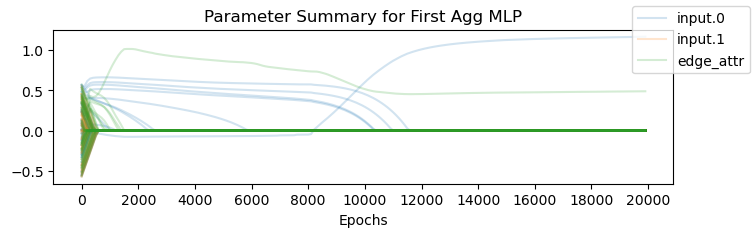

In [12]:
input_0_weights = []
input_1_weights = []
input_edge_weights = []
for checkpoint in checkpoints:
    input_0_weights.append(checkpoint['convs.0.agg_mlp.lins.0.weight'][:,0])
    input_1_weights.append(checkpoint['convs.0.agg_mlp.lins.0.weight'][:,1])
    input_edge_weights.append(checkpoint['convs.0.agg_mlp.lins.0.weight'][:,2])

fig, ax = plt.subplots(1,1, figsize = (8,2))
in0_handle = ax.plot(torch.stack(input_0_weights), c = 'tab:blue', alpha = 0.2)
in1_handle = ax.plot(torch.stack(input_1_weights), c = 'tab:orange', alpha = 0.2)
inedge_handle = ax.plot(torch.stack(input_edge_weights), c = 'tab:green', alpha = 0.2)
ax.set_xticks(range(0, len(checkpoints)+1, len(checkpoints) // 10))
ax.set_xticklabels(range(0, epochs+1, epochs // 10))
ax.set_xlabel('Epochs')
fig.legend([in0_handle[0], in1_handle[0], inedge_handle[0]], ['input.0', 'input.1', 'edge_attr'])
ax.set_title('Parameter Summary for First Agg MLP')

Text(0.5, 1.0, 'Parameter Summary for First Up MLP')

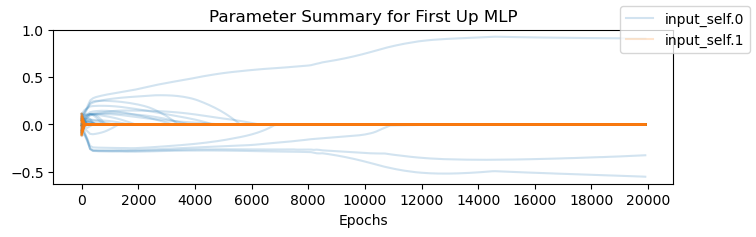

In [13]:
input_self_0_weights = []
input_self_1_weights = []
for checkpoint in checkpoints:
    input_self_0_weights.append(checkpoint['convs.0.up_mlp.lins.0.weight'][:,-2])
    input_self_1_weights.append(checkpoint['convs.0.up_mlp.lins.0.weight'][:,-1])

fig, ax = plt.subplots(1,1, figsize = (8,2))
in0_handle = ax.plot(torch.stack(input_self_0_weights), c = 'tab:blue', alpha = 0.2)
in1_handle = ax.plot(torch.stack(input_self_1_weights), c = 'tab:orange', alpha = 0.2)
ax.set_xticks(range(0, len(checkpoints)+1, len(checkpoints) // 10))
ax.set_xticklabels(range(0, epochs+1, epochs // 10))
ax.set_xlabel('Epochs')
fig.legend([in0_handle[0], in1_handle[0]], ['input_self.0', 'input_self.1'])
ax.set_title('Parameter Summary for First Up MLP')

Text(0.5, 1.0, 'Residual Connections to Up MLP 2')

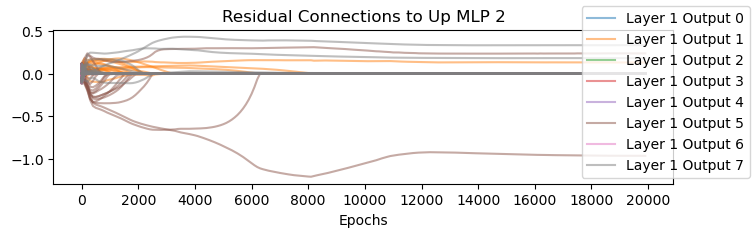

In [18]:
from matplotlib import colors
residual_weights = []
for checkpoint in checkpoints:
    residual_weights.append(checkpoint['convs.1.up_mlp.lins.0.weight'][:,-8:])
residual_weights = torch.stack(residual_weights)

fig, ax = plt.subplots(1,1, figsize = (8,2))
plt_handles = []
for i in range(8):
    plt_handles.append(ax.plot(residual_weights[:,:,i], alpha=0.5, c=list(colors.TABLEAU_COLORS)[i]))
ax.set_xticks(range(0, len(checkpoints)+1, len(checkpoints) // 10))
ax.set_xticklabels(range(0, epochs+1, epochs // 10))
ax.set_xlabel('Epochs')
fig.legend([h[0] for h in plt_handles], [f'Layer 1 Output {i}' for i in range(8)])
ax.set_title('Residual Connections to Up MLP 2')

In [14]:
from tqdm import tqdm
criterion = MultiplicativeLoss()
mse_criterion = torch.nn.MSELoss()
score_methods = ['weight', 'EAP', 'EAP-IG']
circuit_test_losses = {score : [] for score in score_methods}
circuit_bfs_accuracy = {score : [] for score in score_methods}
actual_node_count = {score : [] for score in score_methods}
actual_edge_count = {score : [] for score in score_methods}
pbar = tqdm(range(50))
for K in pbar:
    for score in score_methods:
        for data in test_loader:
            C_tmp = Circuit(model, G, K=K, key=score)
            out = C_tmp.forward(data)
            mul_circuit_loss = float(criterion(out[:,0][data.reachable].flatten(), data.y[data.reachable]).detach()) / len(test_data)
            bfs_accuracy = ((out[:,1].flatten() > 0) == data.reachable).sum().item() / data.num_nodes
            circuit_test_losses[score].append(mul_circuit_loss)
            circuit_bfs_accuracy[score].append(bfs_accuracy)
            actual_node_count[score].append(C_tmp.number_of_nodes())
            actual_edge_count[score].append(C_tmp.number_of_edges())

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████| 50/50 [09:40<00:00, 11.60s/it]


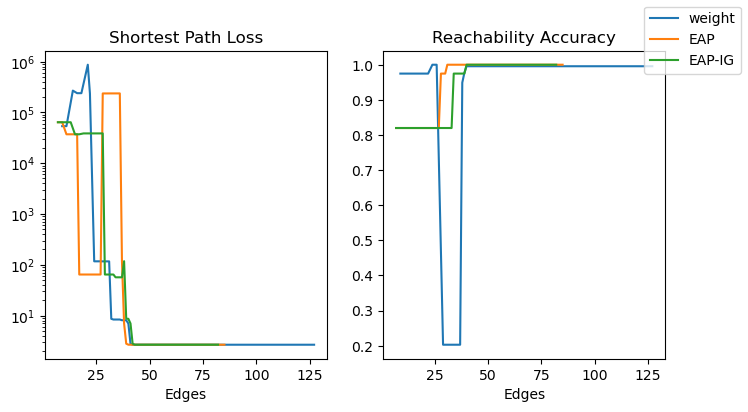

In [15]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
for score in score_methods:
    ax[0].plot(actual_edge_count[score], circuit_test_losses[score], label=f'{score}')
ax[0].set_yscale('log')
ax[0].set_title('Shortest Path Loss')
ax[0].set_xlabel('Edges')
for score in score_methods:
    ax[1].plot(actual_edge_count[score], circuit_bfs_accuracy[score])
ax[1].set_title('Reachability Accuracy')
ax[1].set_xlabel('Edges')
plt.xlabel('Edges')
fig.legend()

In [16]:
l1_regs = torch.load('model_progress/simultaneous/l1_regs.pt')
test_losses = torch.load('model_progress/simultaneous/test_losses.pt')
test_accs = torch.load('model_progress/simultaneous/test_accs.pt')

checkpoints = torch.load('model_progress/simultaneous/model_checkpoints.pt')
circuit_losses = []
circuit_accuracy = []
for checkpoint in checkpoints:
    model.load_state_dict(checkpoint)
    C.model_state_dict = checkpoint
    for data in test_loader:
        out = C.forward(data)
        mul_circuit_loss = criterion(out[:,0][data.reachable].flatten(), data.y[data.reachable]).detach() / num_reachable_test_nodes
        bfs_accuracy = ((out[:,1].flatten() > 0) == data.reachable).sum().item() / data.num_nodes
        circuit_losses.append(float(mul_circuit_loss))
        circuit_accuracy.append(float(bfs_accuracy))

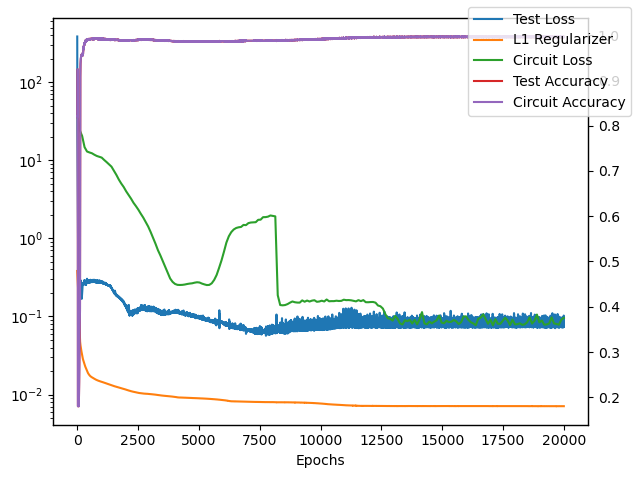

In [17]:
fig, ax = plt.subplots()
ax.plot(test_losses.detach(), label='Test Loss')
ax.plot((eta * l1_regs).detach(), label='L1 Regularizer')

ax2 = ax.twiny()
ax2.plot(circuit_losses, color='tab:green', label='Circuit Loss')

ax3 = ax.twinx()
ax3.plot(test_accs.detach(), color='tab:red', label='Test Accuracy')

ax4 = ax3.twiny()
ax3.plot(test_accs.detach(), color='tab:purple', label='Circuit Accuracy')

ax2.set_xticks([])
ax4.set_xticks([])
ax.set_yscale('log')
ax.set_xlabel('Epochs')

fig.legend()
plt.tight_layout()